<a href="https://colab.research.google.com/github/longhoag/CS4200/blob/main/CS4200_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Name: Long Hoang

!pip install python-chess cairosvg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.5 MB/s eta 0:00:00
  Created wheel for chess: filename=chess-1.11.1-py3-none-any.whl size=148497 sha256=e5990eebbd2bff6bdd4524ed35d8efd7c7babc6a7bdd6dcad771896c91b23130
  Stored in directory: /root/.cache/pip/wheels/2e/2d/23/1bfc95db984ed3ecbf6764167dc7526d0ab521cf9a9852544e
Successfully built chess


In [ ]:
!pwd
!ls
# MAKE SURE TO ADD THE GAME.CSV DATASET TO YOUR CURRENT WORKING DIR

/content
sample_data


In [ ]:
import chess
import chess.pgn
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from IPython.display import SVG, display
from io import StringIO

class ChessGame:
  def __init__(self, model_weights=None):
      self.board = chess.Board()
      self.model = self.load_model()
      if model_weights:
          self.model.load_weights(model_weights)

  def load_model(self):
      """
      Load or create a model for board evaluation.
      """
      model = tf.keras.Sequential([
          tf.keras.layers.Dense(128, activation="relu", input_shape=(64,)),
          tf.keras.layers.Dense(64, activation="relu"),
          tf.keras.layers.Dense(1, activation="sigmoid"),
      ])
      model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
      return model

  def board_to_vector(self, board):
      """
      Convert the board state into a numeric vector.
      """
      pieces = {
          "p": -1, "r": -5, "n": -3, "b": -3, "q": -9, "k": -100,
          "P": 1, "R": 5, "N": 3, "B": 3, "Q": 9, "K": 100,
      }
      vector = []
      for square in chess.SQUARES:
          piece = board.piece_at(square)
          vector.append(pieces.get(piece.symbol(), 0) if piece else 0)
      return np.array(vector)

  def evaluate_board(self, board):
      """
      Evaluate the board using the model and return a score.
      """
      board_vector = self.board_to_vector(board).reshape(1, -1)
      score = self.model.predict(board_vector, verbose=0)[0][0]
      return score

  def suggest_move(self, for_player=False):
      """
      Suggest the best move by evaluating all legal moves.
      If for_player is True, evaluates from the player's perspective (minimizes AI's score).
      """
      best_move = None
      best_score = -float("inf") if not for_player else float("inf")

      for move in self.board.legal_moves:
          self.board.push(move)
          score = self.evaluate_board(self.board)
          self.board.pop()

          if for_player:
              # Minimize score for player's perspective
              if score < best_score:
                  best_score = score
                  best_move = move
          else:
              # Maximize score for AI's perspective
              if score > best_score:
                  best_score = score
                  best_move = move

      return best_move

  def display_board(self, size=400):
      """
      Display the chessboard with adjustable size.
      """
      board_svg = chess.svg.board(self.board, size=size)
      display(SVG(board_svg))

In [ ]:
# You can skip the training part if you include the pre-trained weights in your working directory
# ------------------------------
# Preprocess the Dataset
# ------------------------------
def preprocess_chess_dataset(csv_file):
    df = pd.read_csv(csv_file)
    positions = []
    labels = []

    for idx, row in df.iterrows():
        # Debug print to verify row content
        print(f"Processing row {idx}: moves={row['moves']}, winner={row['winner']}")

        # Skip missing data
        if pd.isna(row["moves"]) or pd.isna(row["winner"]):
            print("Skipping row due to missing data.")
            continue

        moves = row["moves"].split()  # Split moves into a list
        winner = row["winner"].strip().lower()

        # Validate winner
        if winner not in ["white", "black", "draw"]:
            print(f"Skipping row due to invalid winner value: {winner}")
            continue

        # Initialize board and process moves
        board = chess.Board()
        for move in moves:
            try:
                board.push_san(move)  # Use SAN moves
                positions.append(ChessGame().board_to_vector(board))

                # Assign label based on winner
                if winner == "white":
                    labels.append(1)
                elif winner == "black":
                    labels.append(0)
                else:
                    labels.append(0.5)
            except Exception as e:
                print(f"Skipping invalid move: {move} - Error: {e}")
                continue

    if len(positions) == 0:
        raise ValueError("No valid samples found in the dataset. Check your data.")


    X = np.array(positions)
    y = np.array(labels)
    return X, y

In [ ]:
# MAKE SURE YOU HAVE THE RIGHT PATH
path = "/content/games.csv"

df = pd.read_csv(path)

print(df["moves"].shape)
print(df["winner"].shape)

(200,)
(200,)


In [ ]:
# Load and preprocess data
X, y = preprocess_chess_dataset(path)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Processing row 0: moves=d4 f5 Bf4 Nf6 e3 d6 Nc3 Nc6 Bc4 e5 dxe5 dxe5 Qxd8+ Kxd8 O-O-O+ Bd6 Bg5 Ke7 Nd5+ Kf8 Nxf6 gxf6 Bxf6 Rg8 Bxg8 Kxg8 Nf3 Kf7 Bh4 Be6 a3 b5 h3 b4 axb4 Bxb4 Bg3 Bd6 Rd2 a5 Rhd1 f4 exf4 exf4 Bh4 a4 Ng5+ Kf6 Ne4+ Ke5 Nxd6 cxd6 Rxd6 a3 Rxc6 axb2+ Kxb2 Ra2+ Kc3 Ra3+ Kb4, winner=white


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing row 1: moves=e4 e5 Nf3 f5 d3 fxe4 dxe4 Bb4+ Bd2 Bxd2+ Nbxd2 Nf6 Bb5 c6 Ba4 b5 Bb3 d5 exd5 cxd5 c4 Be6 cxd5 Bxd5 Rc1 Bxb3 axb3 O-O Ng5 Ng4 h3 Qxg5 hxg4 Rd8 Rc7 e4 Nxe4 Rxd1+ Kxd1 Qd5+ Nd2 Qxg2 Rf1 Qxg4+ f3 Qg2 f4 Na6 Rc8+ Rxc8 Ke1 Re8+ Ne4 Rxe4+ Kd1 Qxf1+ Kc2 Qxf4 b4 Nxb4+ Kb3 a6 Ka3 Re3+ b3 Nc2+ Kb2 Qf2 Kc1 Re4 b4 Re1+ Kb2 h6 Kc3 h5 Kd3 h4 Kc3 h3 Kd3 h2 Kc3 h1=Q Kd3 Qh3#, winner=black
Processing row 2: moves=e4 c5 Nf3 g6 d4 cxd4 Nxd4 Nc6 Nxc6 bxc6 Nc3 Bg7 Bd2 d5 Be3 d4 Na4 dxe3 Qxd8+ Kxd8 O-O-O+ Ke8 fxe3 Nf6 e5 Nd5 c4, winner=black
Processing row 3: moves=d4 Nf6 c4 g6 Nc3 Bg7 e4 d6 f3 O-O Be3 e5 d5 c6 Bd3 cxd5 exd5 Nbd7 b4 b5 cxb5 e4 Bc2 exf3 Nxf3 Bb7 Bd4 Re8+ Kf1 Nxd5 Nxd5 Bxd5 Bxg7 Bc4+ Bd3 Bxd3+ Qxd3 Kxg7 Qxd6 Re6 Qd4+ Kg8 Kf2 Rc8 Rac1 Rb8 Rhd1 Qb6 Qxb6 Nxb6 Nd4 Rf6+ Kg3 Nd5 Nc6 Rxb5 a4 Rb6 b5 Ne3 Ne7+ Kg7 Re1 Nf5+ Nxf5+ Rxf5 Re7 a6 Rc6 Rxc6 bxc6 Kf8 Ra7 Ra5 c7 Rc5 Ra8+ Ke7 c8=Q, winner=white
Processing row 4: moves=e4 e5 d3 Nf6 Bg5 Nc6 Bxf6 gxf6 a3 Qe7 b4 d6 c4 Be6 Nf3 R

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------------------
# Train the Model
# ------------------------------
def train_model(X_train, y_train, X_test, y_test, model, epochs=10):
    """
    Train the model using the dataset.
    """
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)
    model.save_weights("chess_model.weights.h5")
    return model

# Train the model
chess_game = ChessGame()
chess_game.model = train_model(X_train, y_train, X_test, y_test, chess_game.model, epochs=5)


Epoch 1/5
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5284 - loss: 1.4398 - val_accuracy: 0.5614 - val_loss: 0.7700
Epoch 2/5
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6122 - loss: 0.6295 - val_accuracy: 0.5932 - val_loss: 0.6478
Epoch 3/5
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6387 - loss: 0.5746 - val_accuracy: 0.6208 - val_loss: 0.6821
Epoch 4/5
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6353 - loss: 0.5739 - val_accuracy: 0.6549 - val_loss: 0.5566
Epoch 5/5
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6702 - loss: 0.5303 - val_accuracy: 0.6314 - val_loss: 0.6032


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


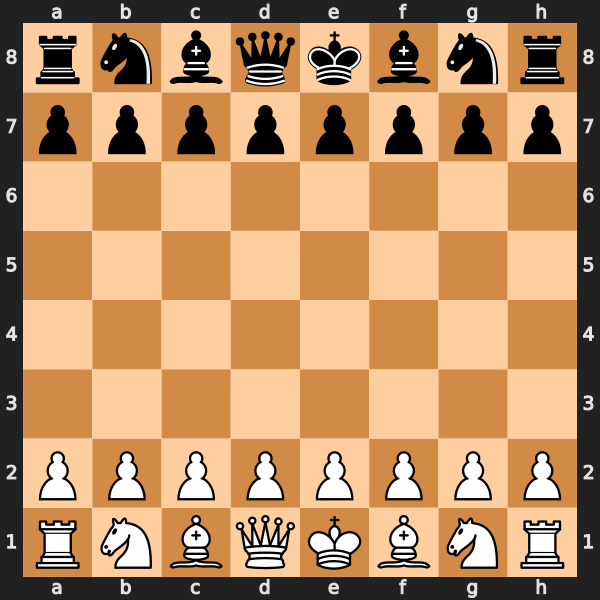

AI is suggesting the best move for you...
Suggested move: b2b4
Enter your move in UCI format (e.g., e2e4): 
b2b4


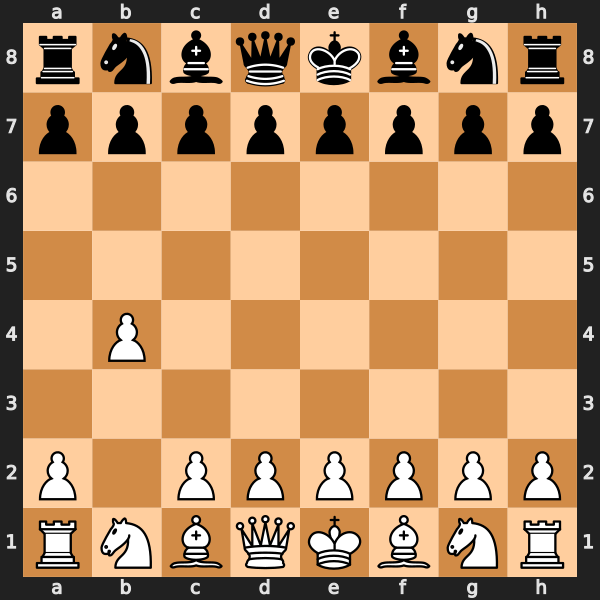

AI is thinking...
AI plays: g7g6


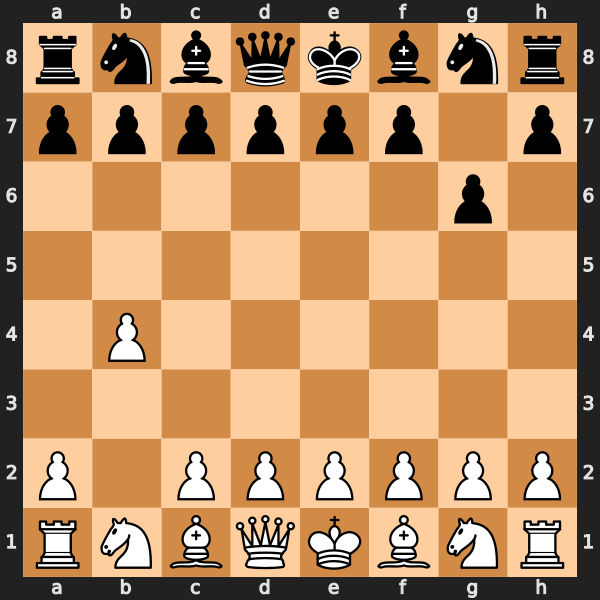

AI is suggesting the best move for you...
Suggested move: g1h3
Enter your move in UCI format (e.g., e2e4): 
g1h3


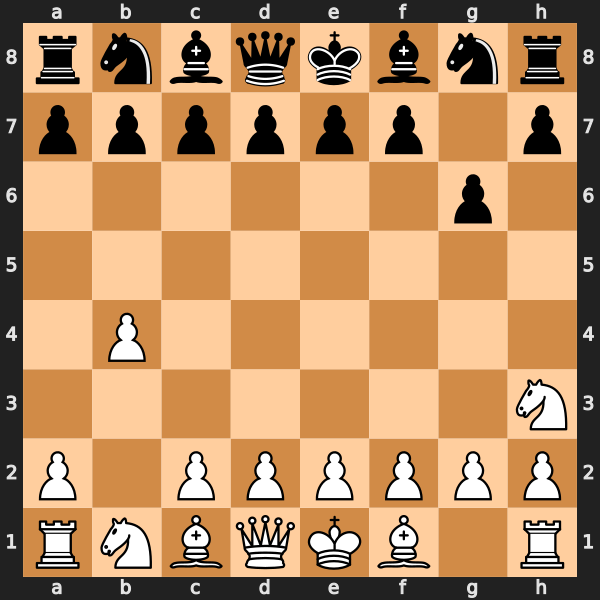

AI is thinking...
AI plays: h7h6


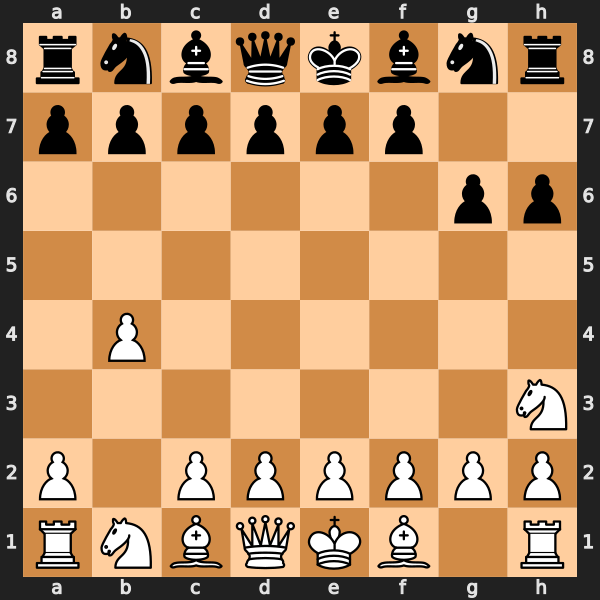

AI is suggesting the best move for you...
Suggested move: c2c4
Enter your move in UCI format (e.g., e2e4): 
c2c4


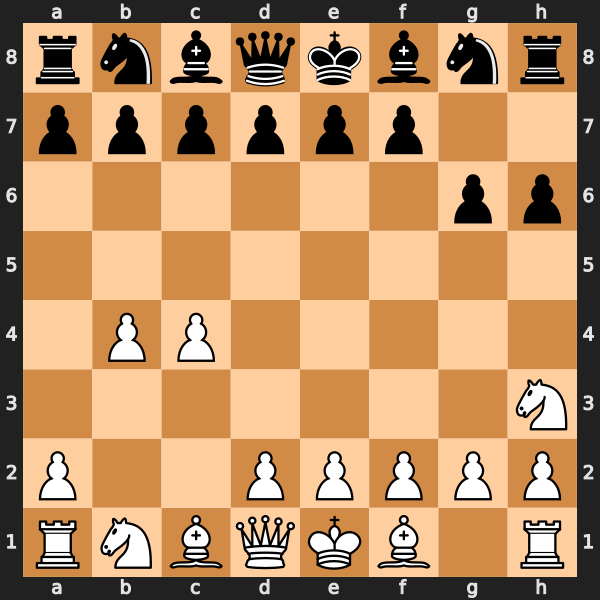

AI is thinking...
AI plays: b7b6


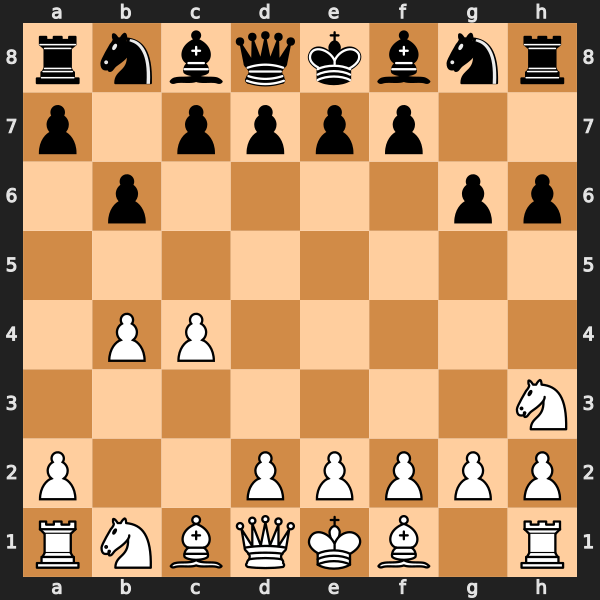

AI is suggesting the best move for you...
Suggested move: d1c2
Enter your move in UCI format (e.g., e2e4): 
d1c2


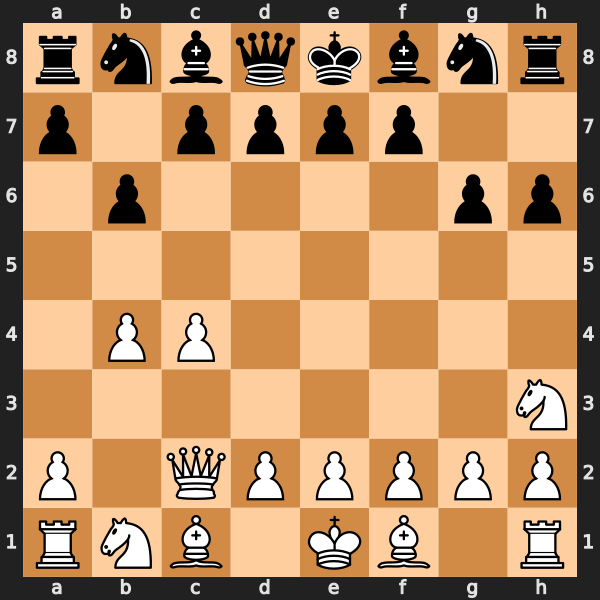

AI is thinking...
AI plays: c8a6


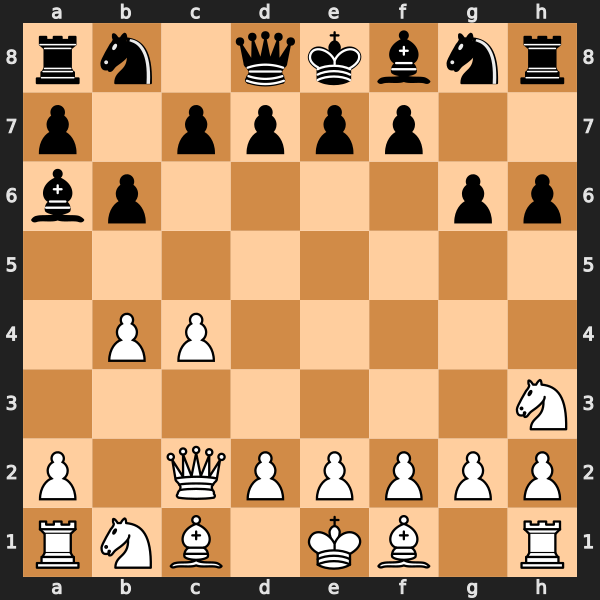

AI is suggesting the best move for you...
Suggested move: e1d1
Enter your move in UCI format (e.g., e2e4): 
e1d1


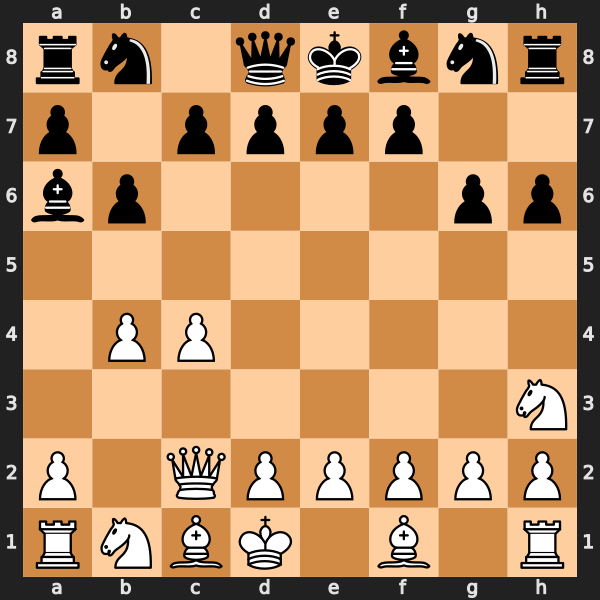

AI is thinking...
AI plays: d8c8


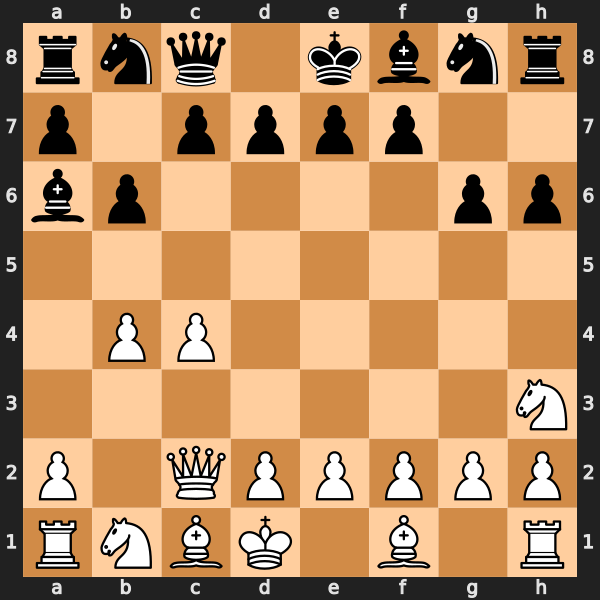

AI is suggesting the best move for you...
Suggested move: h3g5
Enter your move in UCI format (e.g., e2e4): 
h3f4


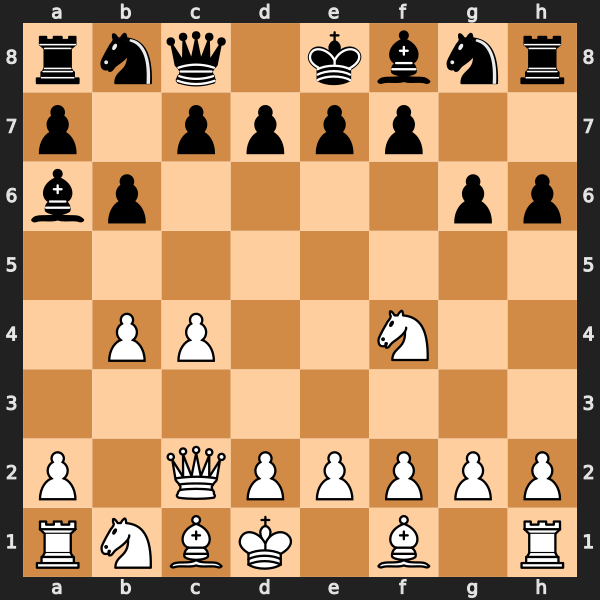

AI is thinking...
AI plays: e8d8


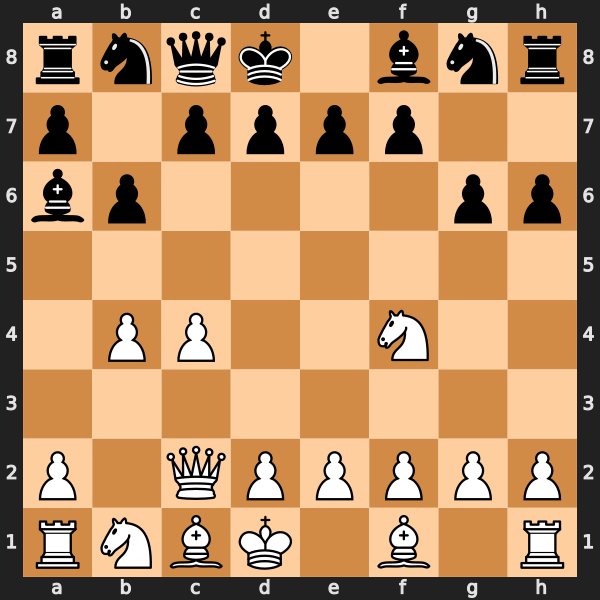

AI is suggesting the best move for you...
Suggested move: d1e1
Enter your move in UCI format (e.g., e2e4): 
f4g6


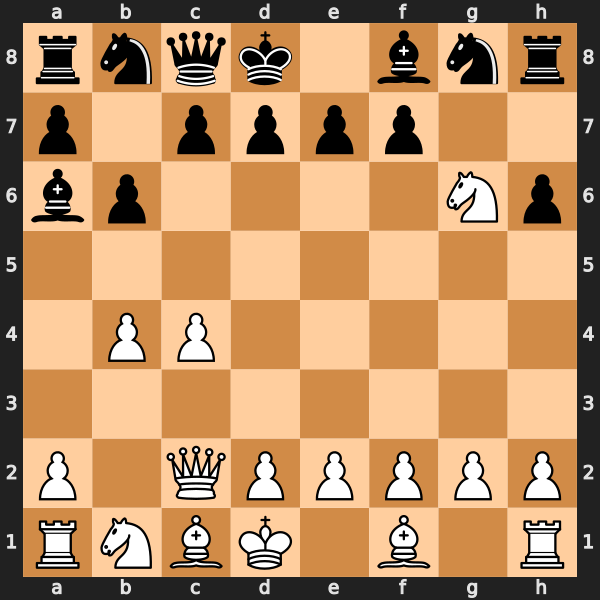

AI is thinking...
AI plays: a6c4


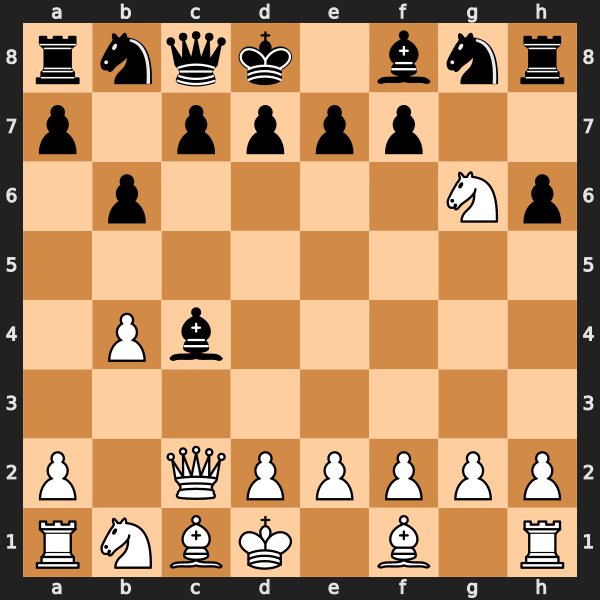

AI is suggesting the best move for you...
Suggested move: d1e1


KeyboardInterrupt: Interrupted by user

In [ ]:
# ------------------------------
# Integrate Trained Model | You can skip the training part if you include the pre-trained weights in your working directory
# ------------------------------
# Initialize the game with trained weights
game = ChessGame(model_weights="chess_model.weights.h5")
game.display_board(size=600)

# Example: Player move
while not game.board.is_game_over():
  print("AI is suggesting the best move for you...")
  player_best_move = game.suggest_move(for_player=True)  # Suggest best move for the player
  if player_best_move:
      print(f"Suggested move: {player_best_move}")

  player_move = input("Enter your move in UCI format (e.g., e2e4): \n")
  try:
      game.board.push_uci(player_move)
  except ValueError:
      print("Invalid move format or illegal move! Please try again.")
      continue

  game.display_board(size=600)

  if game.board.is_game_over():
      print("Game over! No moves left.")
      break

  # AI Move
  print("AI is thinking...")
  ai_move = game.suggest_move()
  if ai_move:
      print(f"AI plays: {ai_move}")
      game.board.push(ai_move)
      game.display_board(size=600)

# I interupt the code by stopping it, not playing until the end. No wrong with the code.
# The code can suggest user the next move, and have the AI plays against the user.
